In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)

HEROKU_URL = os.getenv('HEROKU_POSTGRESQL_AMBER_URL')


In [2]:
# Old Static File
# df = pd.read_pickle("/Users/jenniferdimaano/Desktop/GitHub/rescue-chicago/petfinder-data/data/chicago_il_animals_cleaned.pkl")

# New Heroku DB Connection
# https://pandas.pydata.org/docs/reference/api/pandas.read_sql.html
# EXAMPLE: df = pd.read_sql('test_data', 'postgres:///db_name') 
uri = HEROKU_URL 
if uri.startswith("postgres://"):
    uri = uri.replace("postgres://", "postgresql://", 1)
df = pd.read_sql('petfinder_with_dates', uri)  

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [4]:
#df.head()

In [5]:
# dropping irrelevant columns
df = df.drop(columns=["id", "name", "organization_id", "published_at", "status_changed_at", "attribute_declawed", "city", "state"])

In [6]:
# transform "age" column mapping age and size
age_dict={
'Baby':'0',
'Young':'1',
'Adult':'2',
'Senior':'3'
}
df['age'] = df['age'].map(age_dict).astype(str).astype(int)

In [7]:
# transform "size" column
size_dict={
'Small':'0',
'Medium':'1',
'Large': '2',
'Extra Large': '3'
}
df['size'] = df['size'].map(size_dict).astype(str).astype(int)

In [8]:
# Convert binary columns to binary (0/1) data type
binary_cols = ["breed_mixed", "breed_unknown", "good_with_children", "good_with_dogs", "good_with_cats", "attribute_spayed_neutered",
               "attribute_house_trained", "attribute_shots_current", "attribute_special_needs"]
df[binary_cols] = df[binary_cols].astype(bool).astype(int)

In [9]:
# Replace 'Male' and 'Female' with 0 and 1, respectively
df['gender'] = df['gender'].replace({"Male": 0, "Female": 1})

# Compute the mode of the 'gender' column, ignoring 'Unknown'
mode = df.loc[df['gender'] != 'Unknown', 'gender'].mode()[0]

# Replace 'Unknown' values with the mode
df['gender'] = df['gender'].replace({'Unknown': mode})

In [10]:
# target encoding on larger categorical features
target_cols = ["coat", "organization_name", "breed_primary", "breed_secondary", "color_primary", "color_secondary", "color_tertiary"]
te = ce.TargetEncoder(cols=target_cols)
df[target_cols] = te.fit_transform(df[target_cols], df["los"])

In [11]:
#df.describe()

In [12]:
def remove_outliers(dataframe, columns):
    for col in columns:
        mean = dataframe[col].mean()
        std = dataframe[col].std()
        z_scores = np.abs((dataframe[col] - mean) / std)
        dataframe = dataframe[z_scores <= 3]
    return dataframe

# Remove outliers from Carats, Price, and Retail using Z-score
df = remove_outliers(df, ['organization_name', 'los', 'breed_primary', 'breed_secondary'])

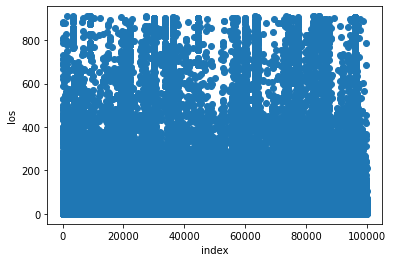

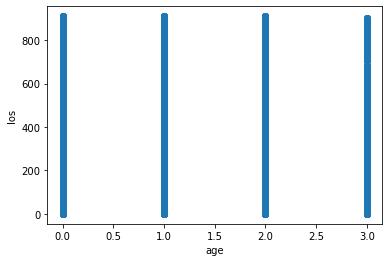

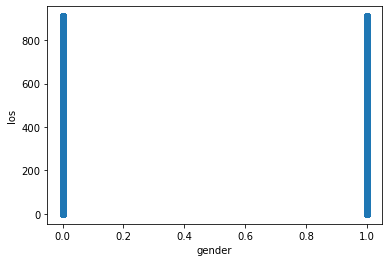

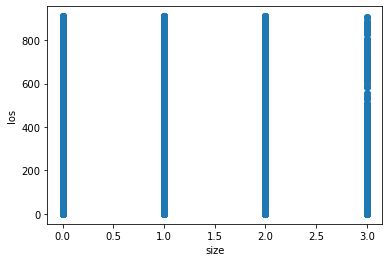

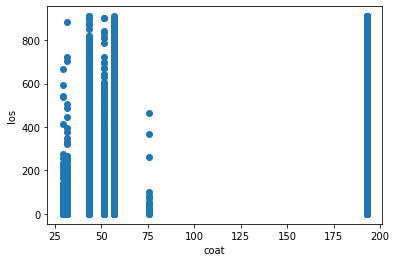

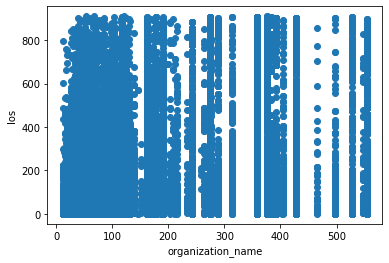

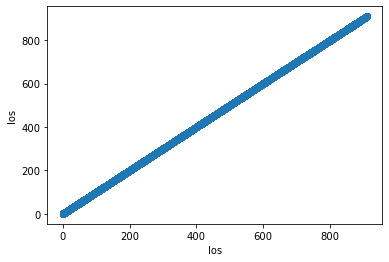

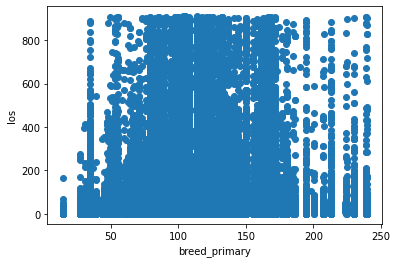

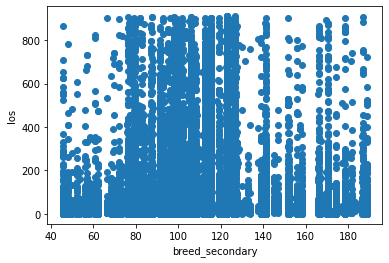

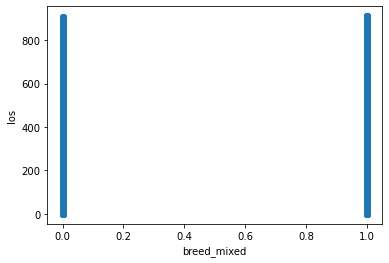

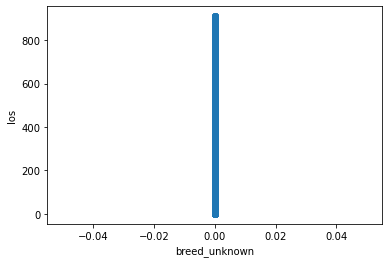

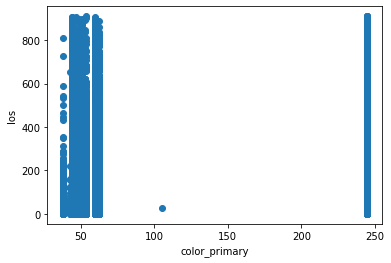

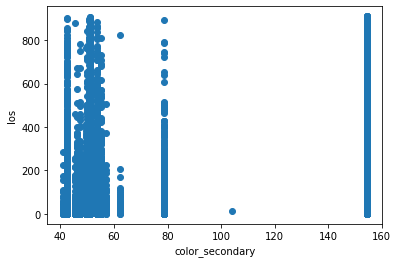

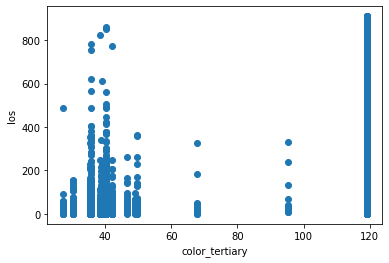

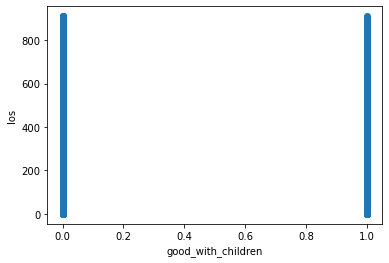

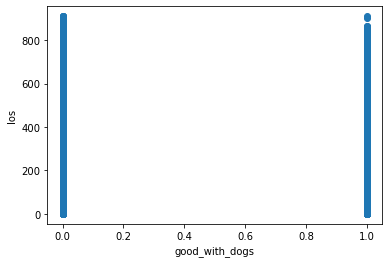

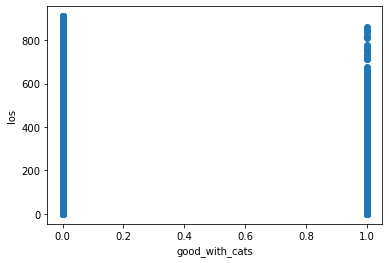

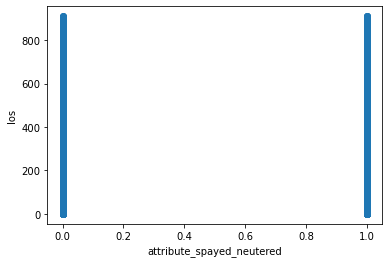

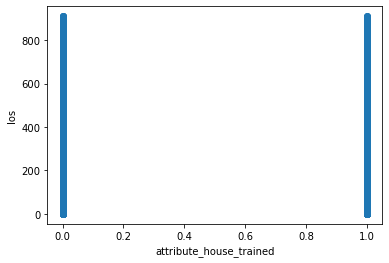

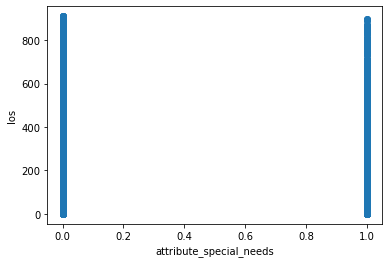

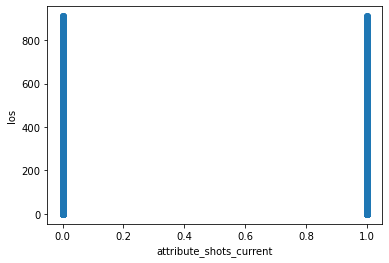

In [13]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()


# Create a scatter plot of numeric features against "los"
for col in num_cols:
    plt.scatter(df[col], df["los"])
    plt.xlabel(col)
    plt.ylabel("los")
    plt.show()


In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], test_size=0.2, random_state=42)

In [15]:
# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the mean squared error of the model
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse)
mae = mean_absolute_error(y_test, y_pred)
print('Mean Absolute Error:', np.mean(mae))
r2 = r2_score(y_test, y_pred)
print('R^2 Score:', np.mean(r2))

Mean squared error: 0.11160354797933464
Mean Absolute Error: 0.24009608892790366
R^2 Score: 0.21830895995538002


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(


In [17]:
df.head()

,index,age,gender,size,coat,organization_name,los,breed_primary,breed_secondary,breed_mixed,breed_unknown,color_primary,color_secondary,color_tertiary,good_with_children,good_with_dogs,good_with_cats,attribute_spayed_neutered,attribute_house_trained,attribute_special_needs,attribute_shots_current
0,0,1,1,0,43.360449,74.791123,27,85.870573,87.105080,1,0,53.603732,154.397827,119.185699,0,0,0,1,1,0,1
1,1,1,1,0,51.536878,74.791123,7,85.197057,122.791397,0,0,59.480904,50.745709,119.185699,0,0,0,1,0,0,1
2,2,2,0,0,43.360449,74.791123,7,55.136602,87.105080,1,0,59.480904,154.397827,119.185699,0,0,0,1,1,0,1
3,3,2,0,0,56.520722,74.791123,56,94.308400,122.791397,0,0,44.190218,154.397827,119.185699,0,0,0,1,1,0,1
4,4,2,0,2,56.520722,74.791123,53,132.077141,122.791397,0,0,53.603732,154.397827,119.185699,0,0,0,1,1,0,1
